Written by AI22BTECH11001

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np

/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aviator98/anaconda3/envs/python3.11_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import torch
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate the lengths for training and validation sets
train_size = int(0.7 * len(full_train_dataset))
val_size = int(0.1 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, _ = torch.utils.data.random_split(full_train_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader)) 

1313 188 313


In [3]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

In [4]:
import numpy as np
import torch

def get_samples_by_label(test_loader, num_classes=10):
    """
    Loops through the test_loader and extracts one sample per label.
    
    Args:
        test_loader (torch.utils.data.DataLoader): The test dataset loader.
        num_classes (int): Number of unique labels to collect samples for.

    Returns:
        np.ndarray: An array of shape (num_classes, 28, 28) containing one sample per class.
        list: List of corresponding labels.
    """
    samples = [None] * num_classes  # Placeholder list for each label
    labels_found = set()

    for images, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in labels_found:  # Store only if not already collected
                samples[label] = images[i].squeeze().numpy()  # Convert to (28,28)
                labels_found.add(label)

            if len(labels_found) == num_classes:  # Stop if all labels are collected
                break
        
        if len(labels_found) == num_classes:
            break

    return np.array(samples), list(labels_found)

# Get one sample per label
samples_np, labels_list = get_samples_by_label(test_loader)

print("Samples shape:", samples_np.shape)  # Expected: (10, 28, 28)
print("Labels:", labels_list)  # Expected: [0, 1, 2, ..., 9]


Samples shape: (10, 28, 28)
Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


cpu


/tmp/ipykernel_11129/2338358794.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_cnn_lime.pth", map_location=device))


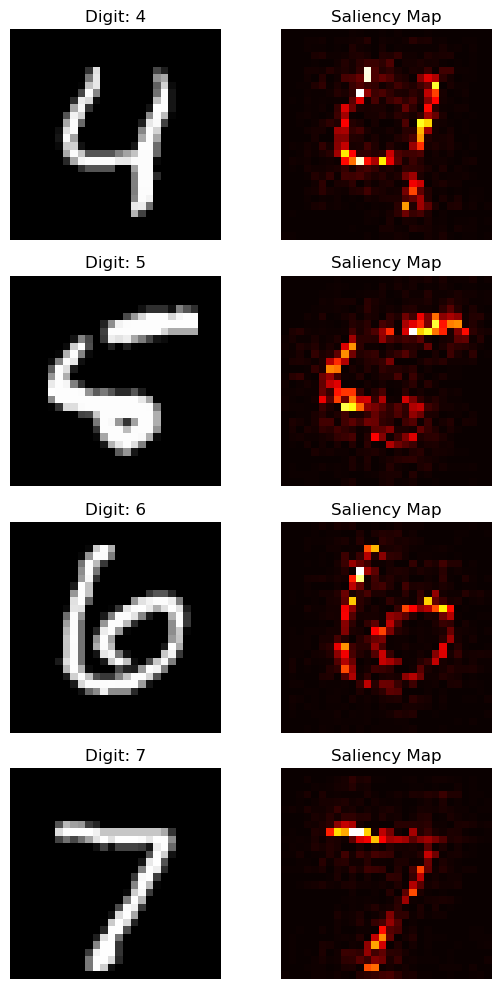

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Load model and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_cnn_lime.pth", map_location=device))
model.eval()

# Function to get one sample for classes 4 to 7
def get_selected_samples(test_loader, selected_classes=[4, 5, 6, 7]):
    selected_samples = {}
    for images, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label in selected_classes and label not in selected_samples:
                selected_samples[label] = images[i].to(device)
            if len(selected_samples) == len(selected_classes):
                return selected_samples
    return selected_samples

# Fetch samples for classes 4 to 7
selected_samples = get_selected_samples(test_loader)

# Generate Saliency Map for each class
fig, axes = plt.subplots(4, 2, figsize=(6, 10))  # 4 rows (digits), 2 columns (original, saliency)

for row_idx, label in enumerate(sorted(selected_samples)):
    image = selected_samples[label]
    image.requires_grad = True

    # Forward pass
    output = model(image.unsqueeze(0))
    predicted_class = output.argmax().item()

    # Compute gradient of predicted class wrt input
    model.zero_grad()
    output[0, predicted_class].backward()

    # Saliency Map = input * gradient
    gradient = image.grad
    saliency_map = image * gradient

    # Convert to NumPy
    saliency_map_np = saliency_map.squeeze().cpu().detach().numpy()
    image_np = image.squeeze().cpu().detach().numpy()

    # Normalize saliency for visualization
    saliency_map_np = np.abs(saliency_map_np)
    saliency_map_np = (saliency_map_np - saliency_map_np.min()) / (saliency_map_np.max() - saliency_map_np.min())

    # Plot original image
    axes[row_idx, 0].imshow(image_np, cmap="gray")
    axes[row_idx, 0].set_title(f"Digit: {label}")
    axes[row_idx, 0].axis("off")

    # Plot saliency map
    axes[row_idx, 1].imshow(saliency_map_np, cmap="hot")
    axes[row_idx, 1].set_title("Saliency Map")
    axes[row_idx, 1].axis("off")

plt.tight_layout()
plt.show()


cpu


/tmp/ipykernel_15125/1411943268.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_cnn_lime.pth", map_location=device))


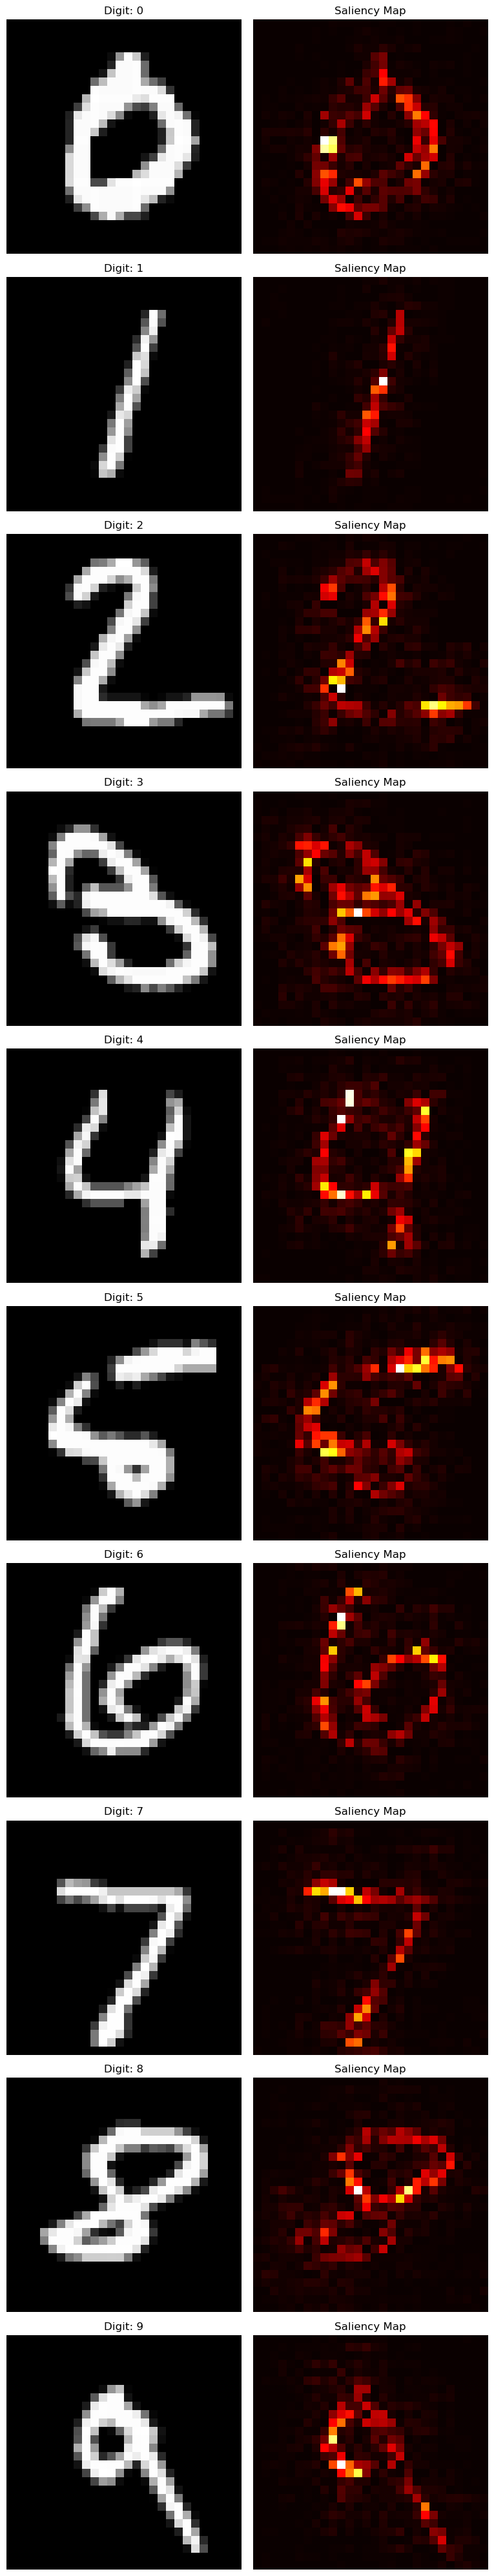

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Load model and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_cnn_lime.pth", map_location=device))
model.eval()

# Function to get one sample per class
def get_one_sample_per_class(test_loader, num_classes=10):
    class_samples = {}
    for images, labels in test_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in class_samples:  # Store only one sample per class
                class_samples[label] = images[i].to(device)
            if len(class_samples) == num_classes:
                return class_samples
    return class_samples

# Fetch one sample for each class
class_samples = get_one_sample_per_class(test_loader)

# Generate Saliency Map for each class
fig, axes = plt.subplots(10, 2, figsize=(8, 40))  # 10 rows (digits), 2 columns (original, saliency)

for label, image in sorted(class_samples.items()):
    image.requires_grad = True  # Enable gradient tracking

    # Forward pass
    output = model(image.unsqueeze(0))  # Add batch dimension
    predicted_class = output.argmax().item()

    # Compute gradient of predicted class wrt input
    model.zero_grad()
    output[0, predicted_class].backward()

    # Compute Gradient-Input Saliency Map
    gradient = image.grad  # Gradient of input wrt model output
    saliency_map = image * gradient  # Element-wise multiplication

    # Convert to NumPy
    saliency_map_np = saliency_map.squeeze().cpu().detach().numpy()
    image_np = image.squeeze().cpu().detach().numpy()

    # Normalize for visualization
    saliency_map_np = np.abs(saliency_map_np)  # Take absolute values
    saliency_map_np = (saliency_map_np - saliency_map_np.min()) / (saliency_map_np.max() - saliency_map_np.min())  # Normalize

    # **Visualize Saliency Map**
    axes[label, 0].imshow(image_np, cmap="gray")
    axes[label, 0].set_title(f"Digit: {label}")
    axes[label, 0].axis("off")

    axes[label, 1].imshow(saliency_map_np, cmap="hot")  # Use "hot" colormap for saliency
    axes[label, 1].set_title("Saliency Map")
    axes[label, 1].axis("off")

plt.tight_layout()
plt.show()
